In [1]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import os
import pickle
from sklearn import preprocessing

Using TensorFlow backend.


In [17]:
def normalize(df,feature_name):
    result = df#.copy()
    mean = df[feature_name].mean()
    std = df[feature_name].std()
    result[feature_name] = (df[feature_name] - mean)/std
    return result

def minmax_scale(df, feature_name):
    result = df#.copy()
    mean = df[feature_name].mean()
    std = df[feature_name].std()
    result[feature_name] = (df[feature_name] - mean)/std
    return result


# preprocessing

raw_df = pd.read_pickle("dataset.pickle")
raw_df = raw_df.reset_index(drop=True)
df = pd.DataFrame()
df['price'] = raw_df['price']
df['date'] = raw_df['date'].astype(int)/1e9
df['latitude'] = raw_df['latitude']
df['longitude'] = raw_df['longitude']
df['area'] = raw_df['area']
df['bedrooms'] = raw_df['bedrooms']
df['pets'] = raw_df['pets']
df['furnished'] = raw_df['furnished']
df['unit_type'] = raw_df['unit_type']

df = normalize(df,'latitude')
df = normalize(df, 'longitude')
df = normalize(df, 'date')
df = normalize(df, 'area')

# categorical variable one-hot encoded
df['unit_type'] = pd.Categorical(df['unit_type'])
dfDummies = pd.get_dummies(df['unit_type'], prefix = 'unit_type_')
df = pd.concat([df, dfDummies], axis=1)
df = df.drop(columns='unit_type')
df = df.drop(columns='date')
mean_price = df['price'].mean()
std_price = df['price'].std()

df = normalize(df, 'price')

# categorical variable one-hot encoded
#df['bedrooms'] = pd.Categorical(df['bedrooms'])
#dfDummies = pd.get_dummies(df['bedrooms'], prefix = 'bedrooms_')
#df = pd.concat([df, dfDummies], axis=1)
#df = df.drop(columns='bedrooms')

X = df.drop(columns='price').to_numpy()
y = df['price'].to_numpy().reshape([-1,1])

print("X Columns: {}",format(df.columns))
print(X.shape)
print(y.shape)



X Columns: {} Index(['price', 'latitude', 'longitude', 'area', 'bedrooms', 'pets',
       'furnished', 'unit_type__apartment', 'unit_type__condo',
       'unit_type__house', 'unit_type__townhouse'],
      dtype='object')
(306414, 10)
(306414, 1)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
def mae(y_pred, y_true):
    p_pred = y_pred*std_price + mean_price
    p_true = y_true*std_price + mean_price
    return abs(p_pred - p_true)

def relative_mae(y_pred, y_true):
    p_pred = y_pred*std_price + mean_price
    p_true = y_true*std_price + mean_price
    
    
    return abs(p_pred - p_true)/p_true

In [20]:
"""Tensorflow-Keras Implementation of Mish"""

## Import Necessary Modules
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [53]:
from keras import regularizers
from keras import optimizers
from keras_radam import RAdam
import keras
lmbda = 1e-6
dropout=0.1
model = Sequential()

model.add(Dense(units=800, activation='relu', input_dim=10, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
model.add(Dense(units=800, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
model.add(Dense(units=800, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
#model.add(Dense(units=400, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
#model.add(Dense(units=400, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
#model.add(Dense(units=400, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
model.add(Dense(units=1, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[mae, relative_mae])

In [54]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=250, 
                    batch_size=32, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[
                        keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                    factor=0.5, 
                                                                    patience=5,
                                                                    verbose=1,
                                                                    mode='auto',
                                                                    min_delta=0.0001,
                                                                    cooldown=0,
                                                                    min_lr=0)
                    ]
)

Train on 196104 samples, validate on 49027 samples
Epoch 1/250
196104/196104 [==============================] - 80s 406us/step - loss: 0.2343 - mae: 351.2612 - relative_mae: 0.1473 - val_loss: 0.2138 - val_mae: 333.0851 - val_relative_mae: 0.1393
Epoch 2/250
196104/196104 [==============================] - 76s 387us/step - loss: 0.2125 - mae: 331.6499 - relative_mae: 0.1387 - val_loss: 0.2058 - val_mae: 324.6398 - val_relative_mae: 0.1349
Epoch 3/250
196104/196104 [==============================] - 76s 388us/step - loss: 0.2057 - mae: 325.2568 - relative_mae: 0.1359 - val_loss: 0.2033 - val_mae: 327.0680 - val_relative_mae: 0.1330
Epoch 4/250
196104/196104 [==============================] - 76s 386us/step - loss: 0.2009 - mae: 321.0210 - relative_mae: 0.1341 - val_loss: 0.2003 - val_mae: 317.7393 - val_relative_mae: 0.1320
Epoch 5/250
196104/196104 [==============================] - 75s 385us/step - loss: 0.1982 - mae: 318.2642 - relative_mae: 0.1329 - val_loss: 0.1968 - val_mae: 317.8

196104/196104 [==============================] - 76s 387us/step - loss: 0.1473 - mae: 269.9844 - relative_mae: 0.1151 - val_loss: 0.1607 - val_mae: 279.9663 - val_relative_mae: 0.1203

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 42/250
196104/196104 [==============================] - 75s 385us/step - loss: 0.1444 - mae: 266.9522 - relative_mae: 0.1140 - val_loss: 0.1578 - val_mae: 276.5842 - val_relative_mae: 0.1176
Epoch 43/250
196104/196104 [==============================] - 75s 383us/step - loss: 0.1437 - mae: 266.4232 - relative_mae: 0.1138 - val_loss: 0.1580 - val_mae: 276.9388 - val_relative_mae: 0.1181
Epoch 44/250
196104/196104 [==============================] - 75s 383us/step - loss: 0.1434 - mae: 265.9859 - relative_mae: 0.1137 - val_loss: 0.1574 - val_mae: 275.5365 - val_relative_mae: 0.1176
Epoch 45/250
196104/196104 [==============================] - 75s 384us/step - loss: 0.1430 - mae: 265.7144 - relative_mae: 0.1136 - val_loss: 0

196104/196104 [==============================] - 75s 383us/step - loss: 0.1351 - mae: 257.7097 - relative_mae: 0.1108 - val_loss: 0.1534 - val_mae: 271.0437 - val_relative_mae: 0.1165
Epoch 82/250
196104/196104 [==============================] - 75s 383us/step - loss: 0.1350 - mae: 257.6314 - relative_mae: 0.1108 - val_loss: 0.1533 - val_mae: 270.9502 - val_relative_mae: 0.1165
Epoch 83/250
196104/196104 [==============================] - 75s 384us/step - loss: 0.1350 - mae: 257.5272 - relative_mae: 0.1108 - val_loss: 0.1533 - val_mae: 271.0792 - val_relative_mae: 0.1161
Epoch 84/250
196104/196104 [==============================] - 75s 383us/step - loss: 0.1349 - mae: 257.4905 - relative_mae: 0.1107 - val_loss: 0.1533 - val_mae: 271.0533 - val_relative_mae: 0.1163

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 85/250
196104/196104 [==============================] - 75s 383us/step - loss: 0.1344 - mae: 256.9889 - relative_mae: 0.1106 - val_loss: 

KeyboardInterrupt: 

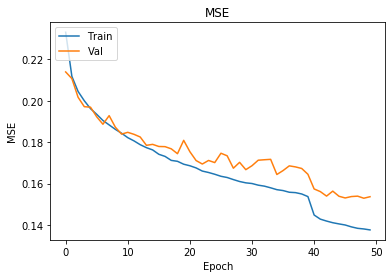

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['mae'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

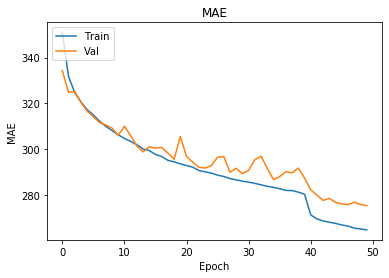

In [56]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
#plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
lambda_ = Input(shape=(1,))
input_1 = Input(shape=x_train.shape[1:])
input_2 = Input(shape=x_train.shape[1:])

###############################

input_ = Input(shape=x_train.shape[1:])

block1 = Dense(units=800, activation='relu', input_dim=10, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda))
block2 = Dense(units=800, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda))


model.add(Dense(units=1, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(lmbda)))

block1 = Model(inputs=input_, outputs=block1, name="block1")


block1_out_1 = block1(input_1)
block1_out_2 = block1(input_2)


###############################
# Manifold Mixup

# lambda_ is conceputally a scalar, but had to encode it into a vector of same length as the batch otherwise keras will complain
layer_mixup = keras.layers.Lambda(lambda inputs: inputs[2][0] * inputs[0] +  (1 - inputs[2][0]) * inputs[1], name="Mixup")
block1_out = layer_mixup([block1_out_1, block1_out_2, lambda_])


###############################
block2_in = Input(shape=block1_out.shape[1:].as_list())

block2 = Conv2D(64, (3,3), padding='same')(block2_in)
block2 = Activation('elu')(block2)
block2 = BatchNormalization()(block2)
block2 = Conv2D(64, (3,3), padding='same')(block2)
block2 = Activation('elu')(block2)
block2 = BatchNormalization()(block2)
block2 = MaxPooling2D()(block2)
block2 = Dropout(0.3)(block2)

block2 = Model(inputs=block2_in, outputs=block2, name="block2")
block2_out = block2(block1_out)
 
###############################
 
final_in = Input(shape=block2_out.shape[1:].as_list())

final = Flatten()(final_in)
final = Dense(num_classes, activation='softmax')(final)

final = Model(inputs=final_in, outputs=final, name="final")
final_out = final(block2_out)


###############################


model = Model(inputs=[input_1, input_2, lambda_], outputs=final_out)
model.summary()